In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
Experiment_name = 'test school without markers  vel follow'
Experiment_note = """

"""

In [5]:
gpuId = 2
control_dt = 0.2
radius=1.0

max_time = 10

action_max= 2
couple_mode =  fl.COUPLE_MODE.TWO_WAY

wa= 1.0
wv = 5.0

use_markers=False
ratio = 0.005/control_dt*(max_time/10)
import torch
torch.cuda.set_device(gpuId)

In [6]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


In [7]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)

# num_train_steps= int(1e6)
# replay_buffer_capacity=int(1e6)
# num_seed_steps=int(100)
eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda"
# logger
log_frequency=1
log_save_tb=True
# video recorder
seed=1

In [8]:

discount=0.99
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
batch_size=int(2048*ratio)
# batch_size = 256
gradient_steps=1
target_update_interval=1
ent_coef= "auto"
target_entropy= "auto" 

# critic settings
critic_net_arch= [256,256]
n_critics = 2
# actor settings
actor_net_arch= [256,256]
actor_log_std_bounds=[-20, 2]

evaluate_save_data = False
evaluate_save_fluid = False



### Import Settings

In [9]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [10]:
fluid_json = json_folder+'fluid_param_school.json'
rigid_json = json_folder+'rigids_4_30_school.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_school.json
/root/pytorch_fish/py_data/jsons/rigids_4_30_school.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [11]:
def plot_infos(infos,title=None,reward_fig_name=None):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    if title:
        plt.title(title)
    if reward_fig_name:
        plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [12]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [13]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from sac.logger import Logger
from sac.agent.replay_buffer import ReplayBuffer

## RL Begin

In [15]:
from sac.agent.sac import SACAgent
from sac.agent.critic import Critic
from sac.agent.actor import DiagGaussianActor

## RL Begin

In [16]:
from gym_fish.envs.fish_env_school import FishEnvSchool
env=FishEnvSchool(gpuId=gpuId,
                    couple_mode=couple_mode,control_dt=control_dt,max_time=max_time,
                    action_max=action_max,
                    rigid_json=rigid_json,use_markers=use_markers,
                     wa=wa,wv=wv,
                    fluid_json=fluid_json
                   ) 


In [17]:
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_space = env.action_space

In [18]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [19]:
logger = Logger(tb_folder,save_tb=log_save_tb,
                             agent="sac")
critic_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)
critic_target_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)

actor_network = DiagGaussianActor( obs_dim, action_dim, actor_net_arch,actor_log_std_bounds)

replay_buffer = ReplayBuffer(env.observation_space.shape,env.action_space.shape,int(replay_buffer_capacity),device)

agent = SACAgent(obs_dim,action_dim,action_space,device,critic_network,critic_target_network,actor_network,replay_buffer, 
                 discount,ent_coef,target_entropy,
                 alpha_lr,alpha_betas,actor_lr,actor_betas,critic_lr,critic_betas,critic_tau,
                 gradient_steps,target_update_interval,batch_size)


In [20]:
step = 0
next_eval_steps= eval_frequency

In [21]:
 def collect_traj(seed_steps=False):
        obs = env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = env.action_space.sample()
            else:
                action = agent.predict(obs, deterministic=False)
            next_obs, reward, done, _ = env.step(action)
            action = agent.scale_action(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = env.reset()
                    done = False
                    reward = 0 
        return samples

In [22]:
def collect_seed_samples():
        step = 0 
        while step<num_seed_steps:
            samples = collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                agent.replay_buffer.add(obs, action, reward, next_obs,done)
                step+=1
                if step>=num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",num_seed_steps)

In [23]:
def evaluate():
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(step)
        best_rewards = -9999
        for episode in range(num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = env.reset()
            agent.reset()
            done = False
            episode_reward = 0
            infos = []
            while not done:
                action=agent.predict(obs, deterministic=True)
                if evaluate_save_data:
                    obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
                else:
                    obs, reward, done, info = env.step(action)
                infos.append(info)
                # video_recorder.record(env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # video_recorder.save(f'{step}.mp4')
        average_episode_reward /= num_eval_episodes
        logger.log('eval/episode_reward', average_episode_reward,step)
        logger.dump(step,ty='eval')

### RL Train

In [24]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Trajectory/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


In [25]:
collect_seed_samples()
episode, episode_reward= 0, 0
start_time = time.time()

Collect seed samples complete. Step:  51  Seed steps: 51


| train | E: 1 | S: 17 | R: 25.8522 | D: 22.2 s | BR: 1.5443 | ALOSS: -3.0835 | CLOSS: 15.2328 | TLOSS: -0.0162 | TVAL: 0.9976 | AENT: -4.0000
| train | E: 2 | S: 36 | R: 29.9174 | D: 24.8 s | BR: 1.5351 | ALOSS: -4.1356 | CLOSS: 9.3012 | TLOSS: -0.0524 | TVAL: 0.9922 | AENT: -4.0000
| train | E: 3 | S: 52 | R: 20.5265 | D: 19.8 s | BR: 1.4529 | ALOSS: -5.5088 | CLOSS: 3.9355 | TLOSS: -0.0879 | TVAL: 0.9870 | AENT: -4.0000
| train | E: 4 | S: 68 | R: 24.6775 | D: 21.2 s | BR: 1.5168 | ALOSS: -6.5869 | CLOSS: 2.9684 | TLOSS: -0.1195 | TVAL: 0.9823 | AENT: -4.0000
| train | E: 5 | S: 87 | R: 29.3327 | D: 22.8 s | BR: 1.5194 | ALOSS: -7.0039 | CLOSS: 2.7586 | TLOSS: -0.1548 | TVAL: 0.9772 | AENT: -4.0000
| train | E: 6 | S: 103 | R: 21.5484 | D: 20.7 s | BR: 1.4627 | ALOSS: -7.0405 | CLOSS: 2.5165 | TLOSS: -0.1898 | TVAL: 0.9721 | AENT: -4.0000
| train | E: 7 | S: 118 | R: 19.9798 | D: 19.3 s | BR: 1.4982 | ALOSS: -7.1890 | CLOSS: 2.4699 | TLOSS: -0.2209 | TVAL: 0.9676 | AENT: -4.0000
| t

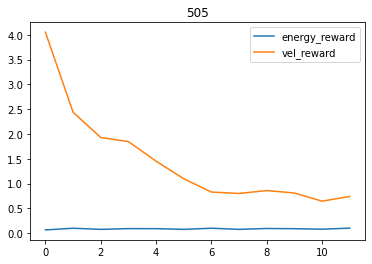

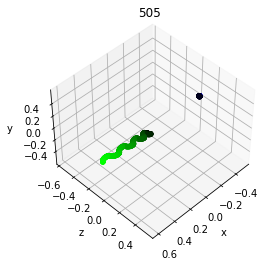

| eval  | E: 27 | S: 505 | R: 16.4499
| train | E: 28 | S: 505 | R: 33.2058 | D: 26.0 s | BR: 1.4617 | ALOSS: -11.8568 | CLOSS: 4.2475 | TLOSS: -0.9568 | TVAL: 0.8633 | AENT: -4.0000
| train | E: 29 | S: 521 | R: 24.8574 | D: 36.4 s | BR: 1.4382 | ALOSS: -11.9574 | CLOSS: 4.1478 | TLOSS: -0.9884 | TVAL: 0.8586 | AENT: -4.0000
| train | E: 30 | S: 539 | R: 23.6487 | D: 22.5 s | BR: 1.4508 | ALOSS: -12.3128 | CLOSS: 4.6045 | TLOSS: -1.0163 | TVAL: 0.8543 | AENT: -4.0000
| train | E: 31 | S: 556 | R: 21.2843 | D: 23.4 s | BR: 1.4206 | ALOSS: -12.4059 | CLOSS: 4.6414 | TLOSS: -1.0487 | TVAL: 0.8499 | AENT: -4.0000
| train | E: 32 | S: 576 | R: 29.2936 | D: 24.5 s | BR: 1.4446 | ALOSS: -12.6217 | CLOSS: 5.4334 | TLOSS: -1.0891 | TVAL: 0.8453 | AENT: -4.0000
| train | E: 33 | S: 597 | R: 29.4737 | D: 25.2 s | BR: 1.4690 | ALOSS: -12.8290 | CLOSS: 5.5395 | TLOSS: -1.1297 | TVAL: 0.8402 | AENT: -4.0000
| train | E: 34 | S: 613 | R: 21.4211 | D: 20.8 s | BR: 1.3999 | ALOSS: -12.9895 | CLOSS: 5.

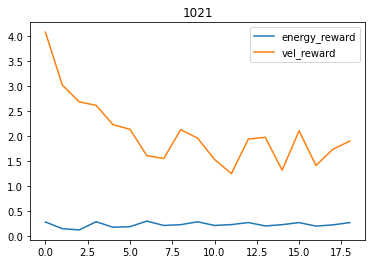

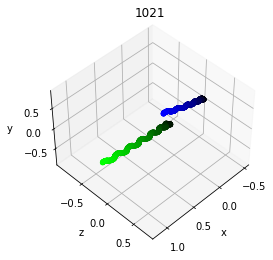

| eval  | E: 55 | S: 1021 | R: 34.7983
| train | E: 56 | S: 1021 | R: 25.1361 | D: 22.2 s | BR: 1.3960 | ALOSS: -17.0210 | CLOSS: 13.6910 | TLOSS: -1.8853 | TVAL: 0.7421 | AENT: -4.0000
| train | E: 57 | S: 1036 | R: 18.5111 | D: 44.9 s | BR: 1.4669 | ALOSS: -17.7843 | CLOSS: 8.1014 | TLOSS: -1.8974 | TVAL: 0.7385 | AENT: -4.0000
| train | E: 58 | S: 1054 | R: 27.1941 | D: 24.8 s | BR: 1.4937 | ALOSS: -17.3167 | CLOSS: 12.1391 | TLOSS: -1.9290 | TVAL: 0.7349 | AENT: -4.0000
| train | E: 59 | S: 1067 | R: 13.9184 | D: 17.7 s | BR: 1.4364 | ALOSS: -17.8699 | CLOSS: 10.5373 | TLOSS: -1.9303 | TVAL: 0.7316 | AENT: -4.0000
| train | E: 60 | S: 1086 | R: 28.5423 | D: 24.8 s | BR: 1.4381 | ALOSS: -17.4088 | CLOSS: 14.0256 | TLOSS: -1.9688 | TVAL: 0.7282 | AENT: -4.0000
| train | E: 61 | S: 1103 | R: 22.3599 | D: 21.2 s | BR: 1.4237 | ALOSS: -17.8428 | CLOSS: 12.6734 | TLOSS: -2.0511 | TVAL: 0.7244 | AENT: -4.0000
| train | E: 62 | S: 1125 | R: 35.1287 | D: 28.6 s | BR: 1.4828 | ALOSS: -18.182

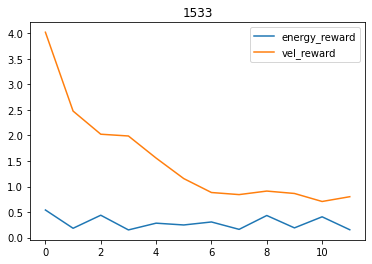

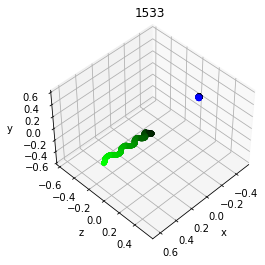

| eval  | E: 83 | S: 1533 | R: 14.7255
| train | E: 84 | S: 1533 | R: 16.5187 | D: 18.6 s | BR: 1.4763 | ALOSS: -21.1861 | CLOSS: 19.5647 | TLOSS: -2.7007 | TVAL: 0.6392 | AENT: -4.0000
| train | E: 85 | S: 1550 | R: 23.5682 | D: 39.8 s | BR: 1.4218 | ALOSS: -21.0227 | CLOSS: 18.3778 | TLOSS: -2.7012 | TVAL: 0.6363 | AENT: -4.0000
| train | E: 86 | S: 1568 | R: 25.1190 | D: 24.1 s | BR: 1.4722 | ALOSS: -21.6320 | CLOSS: 18.0643 | TLOSS: -2.7713 | TVAL: 0.6332 | AENT: -4.0000
| train | E: 87 | S: 1585 | R: 24.0894 | D: 22.5 s | BR: 1.4527 | ALOSS: -21.6826 | CLOSS: 20.3253 | TLOSS: -2.7636 | TVAL: 0.6300 | AENT: -4.0000
| train | E: 88 | S: 1600 | R: 18.9386 | D: 21.1 s | BR: 1.4373 | ALOSS: -21.7155 | CLOSS: 17.9561 | TLOSS: -2.7624 | TVAL: 0.6271 | AENT: -4.0000
| train | E: 89 | S: 1620 | R: 28.2986 | D: 24.1 s | BR: 1.4230 | ALOSS: -21.9188 | CLOSS: 17.6016 | TLOSS: -2.7604 | TVAL: 0.6240 | AENT: -4.0000
| train | E: 90 | S: 1636 | R: 20.5230 | D: 21.8 s | BR: 1.4482 | ALOSS: -22.02

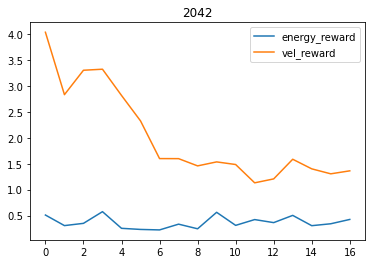

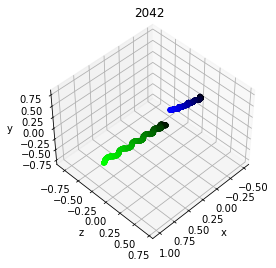

| eval  | E: 113 | S: 2042 | R: 28.0322
| train | E: 114 | S: 2042 | R: 28.4066 | D: 26.7 s | BR: 1.4611 | ALOSS: -24.5964 | CLOSS: 25.3721 | TLOSS: -3.3107 | TVAL: 0.5544 | AENT: -4.0000
| train | E: 115 | S: 2060 | R: 24.7731 | D: 46.0 s | BR: 1.4809 | ALOSS: -24.5190 | CLOSS: 24.8755 | TLOSS: -3.3647 | TVAL: 0.5516 | AENT: -4.0000
| train | E: 116 | S: 2073 | R: 14.0188 | D: 17.4 s | BR: 1.4269 | ALOSS: -25.0643 | CLOSS: 27.0335 | TLOSS: -3.4079 | TVAL: 0.5492 | AENT: -4.0000
| train | E: 117 | S: 2088 | R: 17.1750 | D: 20.9 s | BR: 1.4067 | ALOSS: -24.3491 | CLOSS: 29.2964 | TLOSS: -3.2736 | TVAL: 0.5470 | AENT: -4.0000
| train | E: 118 | S: 2105 | R: 22.5698 | D: 21.5 s | BR: 1.4335 | ALOSS: -24.7139 | CLOSS: 27.6731 | TLOSS: -3.3726 | TVAL: 0.5446 | AENT: -4.0000
| train | E: 119 | S: 2128 | R: 32.8946 | D: 29.1 s | BR: 1.4380 | ALOSS: -24.8355 | CLOSS: 31.3071 | TLOSS: -3.4721 | TVAL: 0.5416 | AENT: -4.0000
| train | E: 120 | S: 2142 | R: 14.7677 | D: 18.5 s | BR: 1.4373 | ALOSS

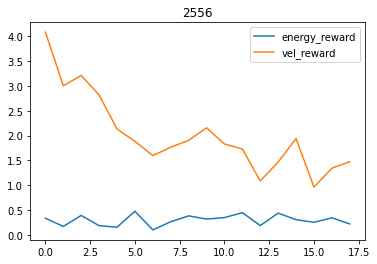

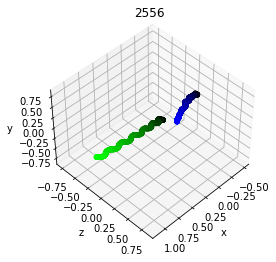

| eval  | E: 142 | S: 2556 | R: 31.0140
| train | E: 143 | S: 2556 | R: 23.7066 | D: 23.5 s | BR: 1.4003 | ALOSS: -26.7859 | CLOSS: 31.7707 | TLOSS: -4.0981 | TVAL: 0.4821 | AENT: -4.0000
| train | E: 144 | S: 2572 | R: 21.3536 | D: 45.5 s | BR: 1.4257 | ALOSS: -26.6810 | CLOSS: 28.9355 | TLOSS: -4.1031 | TVAL: 0.4798 | AENT: -4.0000
| train | E: 145 | S: 2587 | R: 20.6195 | D: 19.4 s | BR: 1.4727 | ALOSS: -27.3472 | CLOSS: 33.5502 | TLOSS: -3.9942 | TVAL: 0.4776 | AENT: -4.0000
| train | E: 146 | S: 2605 | R: 29.6691 | D: 24.2 s | BR: 1.3587 | ALOSS: -26.9439 | CLOSS: 31.5117 | TLOSS: -3.9418 | TVAL: 0.4754 | AENT: -4.0000
| train | E: 147 | S: 2623 | R: 23.4250 | D: 22.5 s | BR: 1.4502 | ALOSS: -27.1571 | CLOSS: 23.1438 | TLOSS: -3.7949 | TVAL: 0.4730 | AENT: -4.0000
| train | E: 148 | S: 2638 | R: 18.6043 | D: 21.2 s | BR: 1.4601 | ALOSS: -27.3036 | CLOSS: 32.1083 | TLOSS: -4.0307 | TVAL: 0.4709 | AENT: -4.0000
| train | E: 149 | S: 2660 | R: 38.9194 | D: 26.2 s | BR: 1.3988 | ALOSS

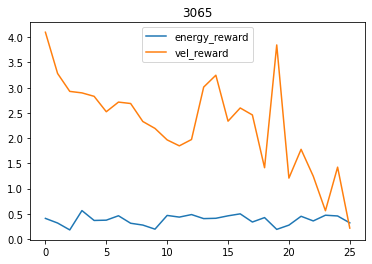

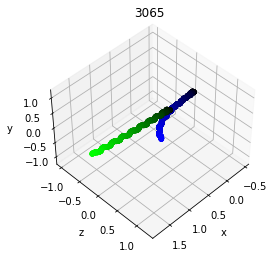

| eval  | E: 167 | S: 3065 | R: 49.7212
| train | E: 168 | S: 3065 | R: 27.6796 | D: 26.5 s | BR: 1.4523 | ALOSS: -28.4684 | CLOSS: 37.9054 | TLOSS: -4.4918 | TVAL: 0.4180 | AENT: -4.0000
| train | E: 169 | S: 3086 | R: 34.6092 | D: 60.0 s | BR: 1.4747 | ALOSS: -28.5893 | CLOSS: 33.0402 | TLOSS: -4.1603 | TVAL: 0.4157 | AENT: -4.0000
| train | E: 170 | S: 3105 | R: 29.0484 | D: 24.8 s | BR: 1.4831 | ALOSS: -28.6489 | CLOSS: 36.9988 | TLOSS: -4.4172 | TVAL: 0.4135 | AENT: -4.0000
| train | E: 171 | S: 3125 | R: 25.2351 | D: 26.7 s | BR: 1.4927 | ALOSS: -29.1675 | CLOSS: 30.0872 | TLOSS: -4.3112 | TVAL: 0.4114 | AENT: -4.0000
| train | E: 172 | S: 3148 | R: 33.9552 | D: 29.3 s | BR: 1.4862 | ALOSS: -29.1058 | CLOSS: 29.3109 | TLOSS: -4.2307 | TVAL: 0.4091 | AENT: -4.0000
| train | E: 173 | S: 3166 | R: 25.0675 | D: 23.8 s | BR: 1.4157 | ALOSS: -29.1287 | CLOSS: 29.5363 | TLOSS: -4.2730 | TVAL: 0.4069 | AENT: -4.0000
| train | E: 174 | S: 3191 | R: 42.4048 | D: 31.4 s | BR: 1.4696 | ALOSS

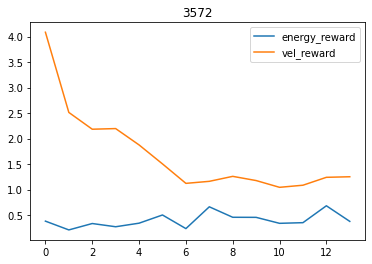

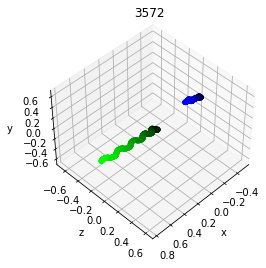

| eval  | E: 193 | S: 3572 | R: 18.1000
| train | E: 194 | S: 3572 | R: 26.5512 | D: 22.7 s | BR: 1.4646 | ALOSS: -29.1566 | CLOSS: 43.3733 | TLOSS: -4.8239 | TVAL: 0.3636 | AENT: -4.0000
| train | E: 195 | S: 3587 | R: 18.6946 | D: 39.0 s | BR: 1.3906 | ALOSS: -29.4924 | CLOSS: 43.2182 | TLOSS: -4.8736 | TVAL: 0.3620 | AENT: -4.0000
| train | E: 196 | S: 3606 | R: 27.7701 | D: 25.5 s | BR: 1.5045 | ALOSS: -29.8732 | CLOSS: 31.7865 | TLOSS: -4.4764 | TVAL: 0.3604 | AENT: -4.0000
| train | E: 197 | S: 3624 | R: 26.2402 | D: 22.7 s | BR: 1.5126 | ALOSS: -29.9641 | CLOSS: 40.5932 | TLOSS: -4.9674 | TVAL: 0.3587 | AENT: -4.0000
| train | E: 198 | S: 3645 | R: 36.4202 | D: 25.8 s | BR: 1.4520 | ALOSS: -30.1081 | CLOSS: 36.5694 | TLOSS: -4.7326 | TVAL: 0.3568 | AENT: -4.0000
| train | E: 199 | S: 3667 | R: 37.7395 | D: 29.0 s | BR: 1.4829 | ALOSS: -29.6463 | CLOSS: 41.8029 | TLOSS: -4.8018 | TVAL: 0.3548 | AENT: -4.0000
| train | E: 200 | S: 3685 | R: 28.1547 | D: 22.4 s | BR: 1.4968 | ALOSS

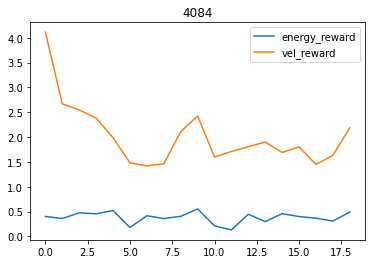

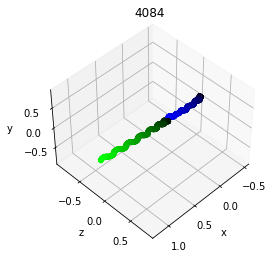

| eval  | E: 215 | S: 4084 | R: 31.1362
| train | E: 216 | S: 4084 | R: 29.2471 | D: 25.5 s | BR: 1.5223 | ALOSS: -31.2001 | CLOSS: 34.9274 | TLOSS: -5.1005 | TVAL: 0.3172 | AENT: -4.0000
| train | E: 217 | S: 4104 | R: 32.8798 | D: 52.5 s | BR: 1.4667 | ALOSS: -31.2870 | CLOSS: 34.7600 | TLOSS: -5.1070 | TVAL: 0.3156 | AENT: -4.0000
| train | E: 218 | S: 4120 | R: 22.9084 | D: 20.6 s | BR: 1.5028 | ALOSS: -31.3022 | CLOSS: 35.9761 | TLOSS: -5.0520 | TVAL: 0.3141 | AENT: -4.0000
| train | E: 219 | S: 4134 | R: 16.7869 | D: 18.7 s | BR: 1.4988 | ALOSS: -31.1249 | CLOSS: 39.0801 | TLOSS: -5.1490 | TVAL: 0.3129 | AENT: -4.0000
| train | E: 220 | S: 4154 | R: 33.3304 | D: 26.7 s | BR: 1.5022 | ALOSS: -31.4179 | CLOSS: 37.7757 | TLOSS: -5.1819 | TVAL: 0.3115 | AENT: -4.0000
| train | E: 221 | S: 4169 | R: 19.6396 | D: 19.3 s | BR: 1.4972 | ALOSS: -31.2312 | CLOSS: 34.6535 | TLOSS: -4.8840 | TVAL: 0.3100 | AENT: -4.0000
| train | E: 222 | S: 4196 | R: 53.5661 | D: 32.7 s | BR: 1.5058 | ALOSS

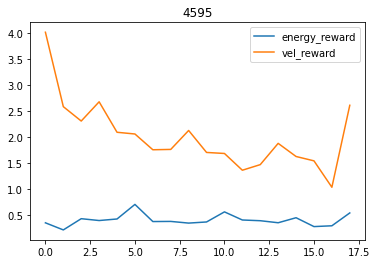

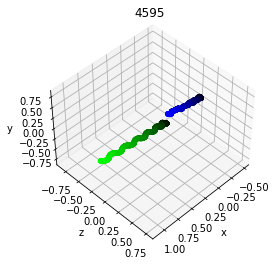

| eval  | E: 240 | S: 4595 | R: 28.9988
| train | E: 241 | S: 4595 | R: 30.9860 | D: 25.3 s | BR: 1.5483 | ALOSS: -32.3407 | CLOSS: 39.8982 | TLOSS: -5.3917 | TVAL: 0.2775 | AENT: -4.0000
| train | E: 242 | S: 4609 | R: 19.2881 | D: 42.8 s | BR: 1.5437 | ALOSS: -31.8979 | CLOSS: 43.1559 | TLOSS: -5.4517 | TVAL: 0.2763 | AENT: -4.0000
| train | E: 243 | S: 4630 | R: 39.1616 | D: 28.3 s | BR: 1.5407 | ALOSS: -32.1389 | CLOSS: 38.4036 | TLOSS: -5.6490 | TVAL: 0.2750 | AENT: -4.0000
| train | E: 244 | S: 4659 | R: 56.9790 | D: 34.0 s | BR: 1.5454 | ALOSS: -32.5400 | CLOSS: 33.3184 | TLOSS: -5.2980 | TVAL: 0.2731 | AENT: -4.0000
| train | E: 245 | S: 4677 | R: 29.0145 | D: 24.0 s | BR: 1.4683 | ALOSS: -32.3407 | CLOSS: 42.9488 | TLOSS: -5.3918 | TVAL: 0.2714 | AENT: -4.0000
| train | E: 246 | S: 4696 | R: 28.9333 | D: 23.4 s | BR: 1.5804 | ALOSS: -32.2711 | CLOSS: 43.5396 | TLOSS: -5.6802 | TVAL: 0.2701 | AENT: -4.0000
| train | E: 247 | S: 4715 | R: 29.2821 | D: 26.3 s | BR: 1.5694 | ALOSS

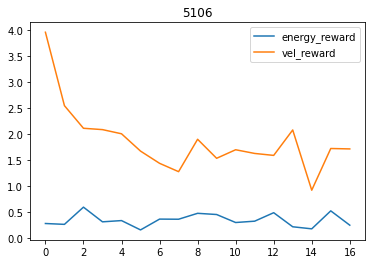

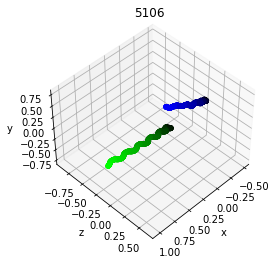

| eval  | E: 265 | S: 5106 | R: 26.0497
| train | E: 266 | S: 5106 | R: 39.6141 | D: 27.7 s | BR: 1.5309 | ALOSS: -32.9456 | CLOSS: 40.8068 | TLOSS: -5.4637 | TVAL: 0.2425 | AENT: -4.0000
| train | E: 267 | S: 5122 | R: 24.8975 | D: 44.3 s | BR: 1.5432 | ALOSS: -32.7490 | CLOSS: 52.0280 | TLOSS: -5.8638 | TVAL: 0.2413 | AENT: -4.0000
| train | E: 268 | S: 5147 | R: 46.2811 | D: 29.7 s | BR: 1.5612 | ALOSS: -33.1040 | CLOSS: 42.6126 | TLOSS: -5.8624 | TVAL: 0.2400 | AENT: -4.0000
| train | E: 269 | S: 5170 | R: 42.5301 | D: 28.1 s | BR: 1.5329 | ALOSS: -33.1171 | CLOSS: 37.8703 | TLOSS: -5.4899 | TVAL: 0.2384 | AENT: -4.0000
| train | E: 270 | S: 5191 | R: 35.7310 | D: 25.3 s | BR: 1.5835 | ALOSS: -33.3071 | CLOSS: 42.9696 | TLOSS: -5.3752 | TVAL: 0.2370 | AENT: -4.0000
| train | E: 271 | S: 5208 | R: 23.4218 | D: 22.9 s | BR: 1.5132 | ALOSS: -33.4414 | CLOSS: 39.2300 | TLOSS: -5.4832 | TVAL: 0.2359 | AENT: -4.0000
| train | E: 272 | S: 5223 | R: 21.5976 | D: 19.5 s | BR: 1.5923 | ALOSS

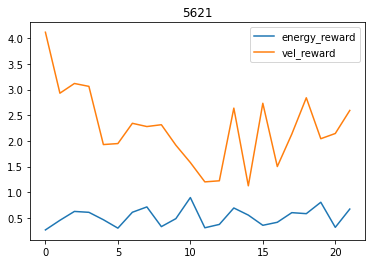

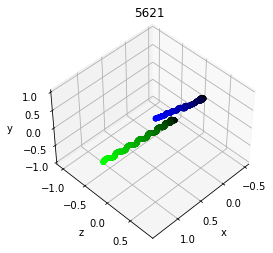

| eval  | E: 291 | S: 5621 | R: 38.3378
| train | E: 292 | S: 5621 | R: 44.5225 | D: 29.6 s | BR: 1.5512 | ALOSS: -33.8999 | CLOSS: 43.2101 | TLOSS: -4.8709 | TVAL: 0.2136 | AENT: -4.0000
| train | E: 293 | S: 5648 | R: 51.4624 | D: 60.4 s | BR: 1.5647 | ALOSS: -34.0683 | CLOSS: 44.0418 | TLOSS: -4.6093 | TVAL: 0.2124 | AENT: -4.0000
| train | E: 294 | S: 5663 | R: 20.0678 | D: 20.5 s | BR: 1.5278 | ALOSS: -34.6584 | CLOSS: 33.3966 | TLOSS: -4.8492 | TVAL: 0.2114 | AENT: -4.0000
| train | E: 295 | S: 5682 | R: 28.9031 | D: 23.3 s | BR: 1.5014 | ALOSS: -33.8704 | CLOSS: 46.6113 | TLOSS: -4.7454 | TVAL: 0.2106 | AENT: -4.0000
| train | E: 296 | S: 5709 | R: 49.2212 | D: 34.5 s | BR: 1.5437 | ALOSS: -34.1641 | CLOSS: 43.7359 | TLOSS: -5.0330 | TVAL: 0.2095 | AENT: -4.0000
| train | E: 297 | S: 5727 | R: 27.4355 | D: 23.0 s | BR: 1.5121 | ALOSS: -33.7681 | CLOSS: 46.8116 | TLOSS: -4.8925 | TVAL: 0.2084 | AENT: -4.0000
| train | E: 298 | S: 5751 | R: 43.1923 | D: 32.3 s | BR: 1.5217 | ALOSS

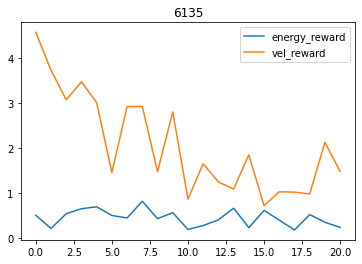

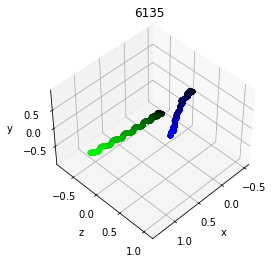

| eval  | E: 314 | S: 6135 | R: 33.9875
| train | E: 315 | S: 6135 | R: 49.0759 | D: 31.7 s | BR: 1.5824 | ALOSS: -34.3642 | CLOSS: 51.5969 | TLOSS: -4.8626 | TVAL: 0.1893 | AENT: -4.0000
| train | E: 316 | S: 6163 | R: 52.6980 | D: 61.2 s | BR: 1.5473 | ALOSS: -33.9295 | CLOSS: 53.2486 | TLOSS: -5.1301 | TVAL: 0.1881 | AENT: -4.0000
| train | E: 317 | S: 6185 | R: 36.6785 | D: 26.8 s | BR: 1.5569 | ALOSS: -34.0175 | CLOSS: 53.1420 | TLOSS: -5.2062 | TVAL: 0.1870 | AENT: -4.0000
| train | E: 318 | S: 6211 | R: 52.5490 | D: 33.6 s | BR: 1.5773 | ALOSS: -34.3283 | CLOSS: 46.1521 | TLOSS: -5.1290 | TVAL: 0.1858 | AENT: -4.0000
| train | E: 319 | S: 6236 | R: 48.8181 | D: 30.3 s | BR: 1.5825 | ALOSS: -34.2276 | CLOSS: 46.6668 | TLOSS: -4.8266 | TVAL: 0.1847 | AENT: -4.0000
| train | E: 320 | S: 6257 | R: 36.9046 | D: 28.2 s | BR: 1.5515 | ALOSS: -34.6574 | CLOSS: 50.4230 | TLOSS: -4.5887 | TVAL: 0.1837 | AENT: -4.0000
| train | E: 321 | S: 6281 | R: 40.9106 | D: 29.2 s | BR: 1.5890 | ALOSS

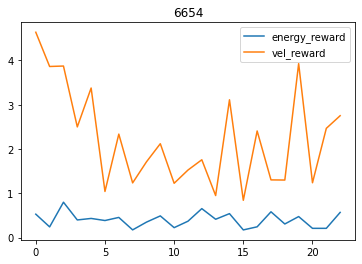

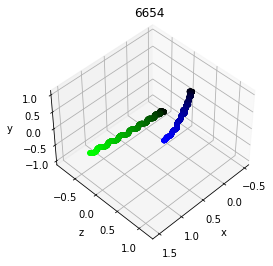

| eval  | E: 335 | S: 6654 | R: 42.2581
| train | E: 336 | S: 6654 | R: 34.3263 | D: 26.0 s | BR: 1.5671 | ALOSS: -35.0184 | CLOSS: 37.1230 | TLOSS: -4.4013 | TVAL: 0.1674 | AENT: -4.0000
| train | E: 337 | S: 6677 | R: 38.3534 | D: 57.2 s | BR: 1.5889 | ALOSS: -34.4063 | CLOSS: 51.2963 | TLOSS: -4.8881 | TVAL: 0.1666 | AENT: -4.0000
| train | E: 338 | S: 6700 | R: 37.3695 | D: 29.7 s | BR: 1.5962 | ALOSS: -34.4342 | CLOSS: 48.4447 | TLOSS: -4.4459 | TVAL: 0.1657 | AENT: -4.0000
| train | E: 339 | S: 6724 | R: 40.3958 | D: 29.8 s | BR: 1.5747 | ALOSS: -34.1114 | CLOSS: 58.0094 | TLOSS: -4.5542 | TVAL: 0.1648 | AENT: -4.0000
| train | E: 340 | S: 6751 | R: 50.1278 | D: 31.6 s | BR: 1.5687 | ALOSS: -34.3988 | CLOSS: 50.6385 | TLOSS: -4.3768 | TVAL: 0.1639 | AENT: -4.0000
| train | E: 341 | S: 6778 | R: 50.8844 | D: 34.9 s | BR: 1.6067 | ALOSS: -34.8491 | CLOSS: 45.1434 | TLOSS: -3.5177 | TVAL: 0.1630 | AENT: -4.0000
| train | E: 342 | S: 6799 | R: 36.0699 | D: 27.0 s | BR: 1.6072 | ALOSS

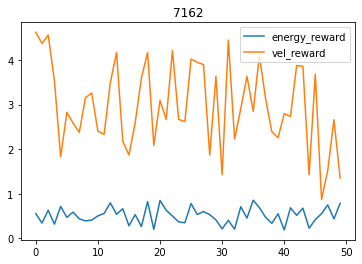

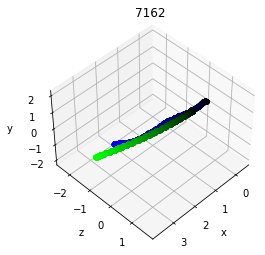

| eval  | E: 352 | S: 7162 | R: 123.0117
| train | E: 353 | S: 7162 | R: 35.6446 | D: 25.3 s | BR: 1.6322 | ALOSS: -35.5778 | CLOSS: 50.9575 | TLOSS: -3.4468 | TVAL: 0.1510 | AENT: -4.0000
| train | E: 354 | S: 7201 | R: 80.9807 | D: 105.6 s | BR: 1.6151 | ALOSS: -35.0935 | CLOSS: 49.8444 | TLOSS: -4.0362 | TVAL: 0.1501 | AENT: -4.0000
| train | E: 355 | S: 7222 | R: 36.4385 | D: 28.8 s | BR: 1.6238 | ALOSS: -35.7251 | CLOSS: 43.9296 | TLOSS: -3.7018 | TVAL: 0.1491 | AENT: -4.0000
| train | E: 356 | S: 7263 | R: 87.4760 | D: 49.3 s | BR: 1.6291 | ALOSS: -35.2351 | CLOSS: 50.8102 | TLOSS: -4.1583 | TVAL: 0.1481 | AENT: -4.0000
| train | E: 357 | S: 7295 | R: 64.9408 | D: 40.5 s | BR: 1.5630 | ALOSS: -35.4067 | CLOSS: 49.4123 | TLOSS: -3.5747 | TVAL: 0.1470 | AENT: -4.0000
| train | E: 358 | S: 7341 | R: 104.3542 | D: 51.6 s | BR: 1.6166 | ALOSS: -35.6880 | CLOSS: 47.0025 | TLOSS: -3.3984 | TVAL: 0.1459 | AENT: -4.0000
| train | E: 359 | S: 7363 | R: 36.7753 | D: 29.1 s | BR: 1.6072 | AL

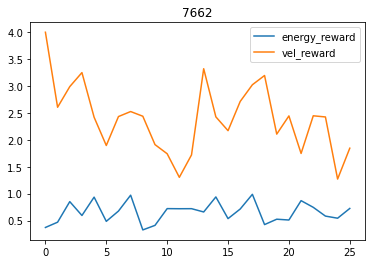

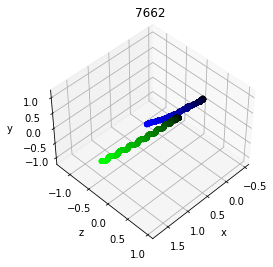

| eval  | E: 370 | S: 7662 | R: 45.3136
| train | E: 371 | S: 7662 | R: 23.6245 | D: 25.2 s | BR: 1.6140 | ALOSS: -35.9312 | CLOSS: 52.6522 | TLOSS: -3.3343 | TVAL: 0.1372 | AENT: -4.0000
| train | E: 372 | S: 7681 | R: 28.5712 | D: 56.8 s | BR: 1.6300 | ALOSS: -36.1207 | CLOSS: 51.9260 | TLOSS: -2.7362 | TVAL: 0.1367 | AENT: -4.0000
| train | E: 373 | S: 7709 | R: 50.1185 | D: 33.6 s | BR: 1.6510 | ALOSS: -36.5522 | CLOSS: 43.8141 | TLOSS: -2.4242 | TVAL: 0.1362 | AENT: -4.0000
| train | E: 374 | S: 7726 | R: 25.8108 | D: 24.5 s | BR: 1.5669 | ALOSS: -35.6530 | CLOSS: 69.5865 | TLOSS: -3.1329 | TVAL: 0.1357 | AENT: -4.0000
| train | E: 375 | S: 7745 | R: 27.9442 | D: 23.8 s | BR: 1.6120 | ALOSS: -36.3827 | CLOSS: 47.1638 | TLOSS: -3.3832 | TVAL: 0.1353 | AENT: -4.0000
| train | E: 376 | S: 7769 | R: 37.5688 | D: 33.1 s | BR: 1.6421 | ALOSS: -35.6553 | CLOSS: 63.5006 | TLOSS: -3.2466 | TVAL: 0.1347 | AENT: -4.0000
| train | E: 377 | S: 7789 | R: 27.4198 | D: 24.5 s | BR: 1.6782 | ALOSS

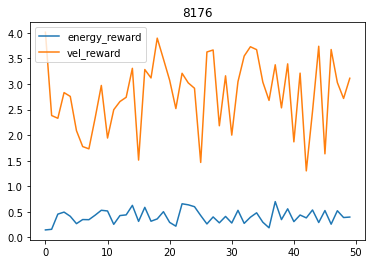

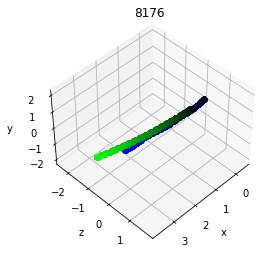

| eval  | E: 390 | S: 8176 | R: 119.9710
| train | E: 391 | S: 8176 | R: 75.4475 | D: 41.1 s | BR: 1.6398 | ALOSS: -36.4755 | CLOSS: 50.4168 | TLOSS: -3.8390 | TVAL: 0.1242 | AENT: -4.0000
| train | E: 392 | S: 8212 | R: 66.9171 | D: 103.8 s | BR: 1.6604 | ALOSS: -36.2175 | CLOSS: 55.1592 | TLOSS: -4.4949 | TVAL: 0.1230 | AENT: -4.0000
| train | E: 393 | S: 8235 | R: 39.2364 | D: 29.8 s | BR: 1.6336 | ALOSS: -36.8998 | CLOSS: 46.9583 | TLOSS: -2.6626 | TVAL: 0.1221 | AENT: -4.0000
| train | E: 394 | S: 8265 | R: 58.8987 | D: 35.0 s | BR: 1.6517 | ALOSS: -36.6812 | CLOSS: 44.2427 | TLOSS: -3.2863 | TVAL: 0.1215 | AENT: -4.0000
| train | E: 395 | S: 8315 | R: 110.5339 | D: 60.2 s | BR: 1.6491 | ALOSS: -36.5839 | CLOSS: 51.9804 | TLOSS: -2.9350 | TVAL: 0.1205 | AENT: -4.0000
| train | E: 396 | S: 8363 | R: 93.6393 | D: 53.3 s | BR: 1.6311 | ALOSS: -36.6682 | CLOSS: 53.9368 | TLOSS: -3.1673 | TVAL: 0.1193 | AENT: -4.0000
| train | E: 397 | S: 8413 | R: 102.3484 | D: 55.8 s | BR: 1.6357 | A

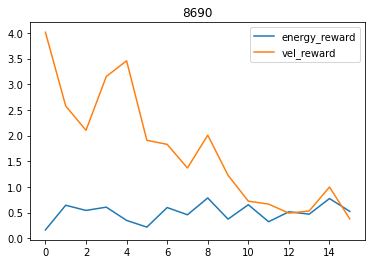

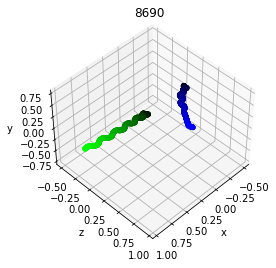

| eval  | E: 405 | S: 8690 | R: 19.4446
| train | E: 406 | S: 8690 | R: 25.3241 | D: 23.8 s | BR: 1.6608 | ALOSS: -37.2450 | CLOSS: 40.9351 | TLOSS: -2.2697 | TVAL: 0.1112 | AENT: -4.0000
| train | E: 407 | S: 8713 | R: 34.9243 | D: 50.7 s | BR: 1.6121 | ALOSS: -37.0060 | CLOSS: 57.0218 | TLOSS: -2.2047 | TVAL: 0.1109 | AENT: -4.0000
| train | E: 408 | S: 8731 | R: 21.8773 | D: 22.4 s | BR: 1.7143 | ALOSS: -37.2120 | CLOSS: 41.5413 | TLOSS: -3.9390 | TVAL: 0.1105 | AENT: -4.0000
| train | E: 409 | S: 8752 | R: 32.4784 | D: 26.0 s | BR: 1.6310 | ALOSS: -36.6591 | CLOSS: 57.8963 | TLOSS: -2.2114 | TVAL: 0.1100 | AENT: -4.0000
| train | E: 410 | S: 8794 | R: 86.2536 | D: 47.2 s | BR: 1.6189 | ALOSS: -37.4580 | CLOSS: 43.0432 | TLOSS: -2.4345 | TVAL: 0.1094 | AENT: -4.0000
| train | E: 411 | S: 8844 | R: 107.7696 | D: 56.8 s | BR: 1.6245 | ALOSS: -37.0499 | CLOSS: 53.4443 | TLOSS: -2.4576 | TVAL: 0.1085 | AENT: -4.0000
| train | E: 412 | S: 8894 | R: 106.6696 | D: 56.2 s | BR: 1.6556 | ALO

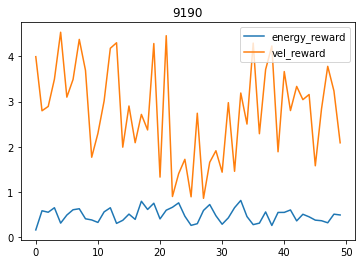

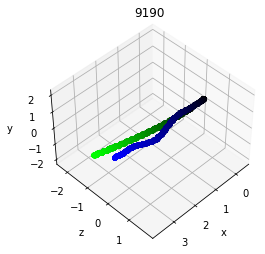

| eval  | E: 418 | S: 9190 | R: 115.2807
| train | E: 419 | S: 9190 | R: 102.1703 | D: 55.2 s | BR: 1.6917 | ALOSS: -37.6452 | CLOSS: 53.9154 | TLOSS: -2.2808 | TVAL: 0.1020 | AENT: -4.0000
| train | E: 420 | S: 9240 | R: 92.0693 | D: 118.1 s | BR: 1.6547 | ALOSS: -37.8750 | CLOSS: 44.3037 | TLOSS: -2.8308 | TVAL: 0.1010 | AENT: -4.0000
| train | E: 421 | S: 9255 | R: 16.9391 | D: 20.2 s | BR: 1.6976 | ALOSS: -37.9789 | CLOSS: 46.9741 | TLOSS: -2.5986 | TVAL: 0.1003 | AENT: -4.0000
| train | E: 422 | S: 9277 | R: 35.0770 | D: 27.0 s | BR: 1.6711 | ALOSS: -37.7920 | CLOSS: 48.5124 | TLOSS: -1.4865 | TVAL: 0.1000 | AENT: -4.0000
| train | E: 423 | S: 9297 | R: 31.5380 | D: 26.4 s | BR: 1.6567 | ALOSS: -37.9000 | CLOSS: 48.2852 | TLOSS: -1.4325 | TVAL: 0.0997 | AENT: -4.0000
| train | E: 424 | S: 9315 | R: 22.2066 | D: 24.2 s | BR: 1.6483 | ALOSS: -37.4890 | CLOSS: 58.0022 | TLOSS: -1.8918 | TVAL: 0.0995 | AENT: -4.0000
| train | E: 425 | S: 9365 | R: 103.2659 | D: 56.2 s | BR: 1.6654 | A

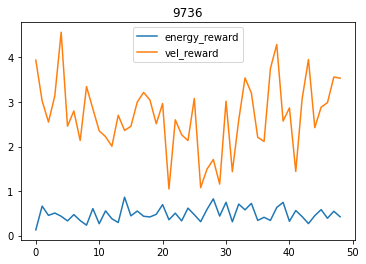

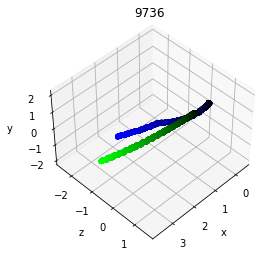

| eval  | E: 434 | S: 9736 | R: 108.1599
| train | E: 435 | S: 9736 | R: 115.5791 | D: 56.9 s | BR: 1.6638 | ALOSS: -38.1777 | CLOSS: 49.0581 | TLOSS: -2.3285 | TVAL: 0.0924 | AENT: -4.0000
| train | E: 436 | S: 9774 | R: 79.6368 | D: 104.4 s | BR: 1.6855 | ALOSS: -38.5383 | CLOSS: 54.1683 | TLOSS: -2.1714 | TVAL: 0.0916 | AENT: -4.0000
| train | E: 437 | S: 9796 | R: 35.6426 | D: 31.1 s | BR: 1.7429 | ALOSS: -38.4250 | CLOSS: 55.4889 | TLOSS: -2.4569 | TVAL: 0.0911 | AENT: -4.0000
| train | E: 438 | S: 9823 | R: 49.5752 | D: 32.5 s | BR: 1.6597 | ALOSS: -38.5604 | CLOSS: 51.4389 | TLOSS: -1.9155 | TVAL: 0.0906 | AENT: -4.0000
| train | E: 439 | S: 9858 | R: 73.1880 | D: 46.5 s | BR: 1.6744 | ALOSS: -38.5619 | CLOSS: 52.7643 | TLOSS: -1.9639 | TVAL: 0.0901 | AENT: -4.0000
| train | E: 440 | S: 9879 | R: 34.9366 | D: 25.9 s | BR: 1.6551 | ALOSS: -38.6924 | CLOSS: 48.7510 | TLOSS: -0.4020 | TVAL: 0.0898 | AENT: -4.0000
| train | E: 441 | S: 9902 | R: 36.6131 | D: 30.8 s | BR: 1.6850 | AL

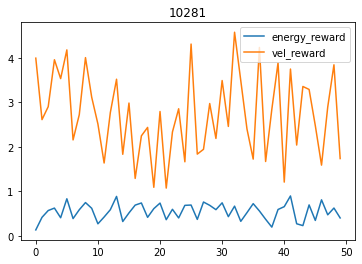

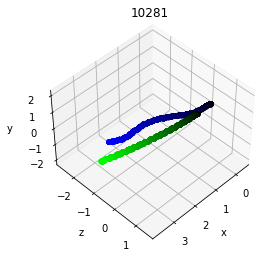

| eval  | E: 448 | S: 10281 | R: 109.2017
| train | E: 449 | S: 10281 | R: 115.9725 | D: 60.5 s | BR: 1.6826 | ALOSS: -39.4599 | CLOSS: 49.7073 | TLOSS: 0.1391 | TVAL: 0.0877 | AENT: -4.0000
| train | E: 450 | S: 10331 | R: 116.0218 | D: 119.0 s | BR: 1.7259 | ALOSS: -39.6367 | CLOSS: 53.9566 | TLOSS: -0.8294 | TVAL: 0.0875 | AENT: -4.0000
| train | E: 451 | S: 10356 | R: 40.5938 | D: 29.8 s | BR: 1.6933 | ALOSS: -39.5437 | CLOSS: 54.6105 | TLOSS: -0.0927 | TVAL: 0.0873 | AENT: -4.0000
| train | E: 452 | S: 10406 | R: 122.9154 | D: 60.1 s | BR: 1.7426 | ALOSS: -39.9790 | CLOSS: 53.6759 | TLOSS: 0.6163 | TVAL: 0.0874 | AENT: -4.0000
| train | E: 453 | S: 10456 | R: 117.7239 | D: 56.4 s | BR: 1.6903 | ALOSS: -39.6776 | CLOSS: 59.6763 | TLOSS: -0.0438 | TVAL: 0.0875 | AENT: -4.0000
| train | E: 454 | S: 10479 | R: 38.8273 | D: 31.4 s | BR: 1.7371 | ALOSS: -40.1517 | CLOSS: 53.6666 | TLOSS: 0.6931 | TVAL: 0.0876 | AENT: -4.0000
| train | E: 455 | S: 10516 | R: 72.1225 | D: 42.2 s | BR: 1.7

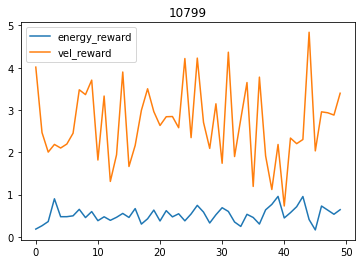

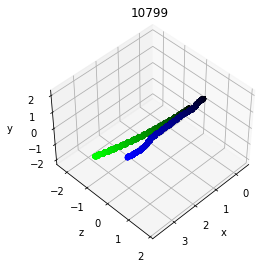

| eval  | E: 461 | S: 10799 | R: 108.3722
| train | E: 462 | S: 10799 | R: 121.2855 | D: 60.1 s | BR: 1.7693 | ALOSS: -40.3742 | CLOSS: 59.6663 | TLOSS: -0.1419 | TVAL: 0.0880 | AENT: -4.0000
| train | E: 463 | S: 10849 | R: 122.7561 | D: 117.4 s | BR: 1.7187 | ALOSS: -40.2044 | CLOSS: 64.0024 | TLOSS: 0.1464 | TVAL: 0.0880 | AENT: -4.0000
| train | E: 464 | S: 10890 | R: 92.1750 | D: 46.7 s | BR: 1.7171 | ALOSS: -40.6310 | CLOSS: 48.8014 | TLOSS: 0.1959 | TVAL: 0.0881 | AENT: -4.0000
| train | E: 465 | S: 10915 | R: 43.8406 | D: 31.5 s | BR: 1.7167 | ALOSS: -40.4144 | CLOSS: 59.9547 | TLOSS: -0.8502 | TVAL: 0.0880 | AENT: -4.0000
| train | E: 466 | S: 10946 | R: 60.5642 | D: 36.3 s | BR: 1.6893 | ALOSS: -40.6672 | CLOSS: 52.4400 | TLOSS: 0.8118 | TVAL: 0.0879 | AENT: -4.0000
| train | E: 467 | S: 10996 | R: 121.2054 | D: 61.6 s | BR: 1.7629 | ALOSS: -40.6767 | CLOSS: 59.0233 | TLOSS: -0.0776 | TVAL: 0.0882 | AENT: -4.0000
| train | E: 468 | S: 11046 | R: 110.0826 | D: 57.0 s | BR: 1.7

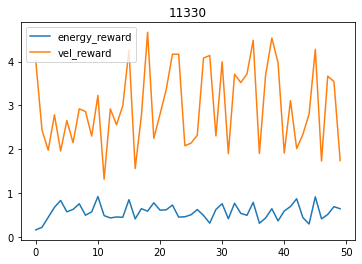

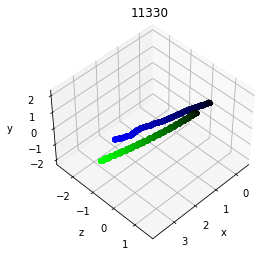

| eval  | E: 475 | S: 11330 | R: 120.3369
| train | E: 476 | S: 11330 | R: 95.5646 | D: 47.7 s | BR: 1.7340 | ALOSS: -41.2680 | CLOSS: 57.7210 | TLOSS: 0.0402 | TVAL: 0.0873 | AENT: -4.0000
| train | E: 477 | S: 11374 | R: 91.2392 | D: 110.4 s | BR: 1.7424 | ALOSS: -41.0222 | CLOSS: 58.9582 | TLOSS: -0.1591 | TVAL: 0.0873 | AENT: -4.0000
| train | E: 478 | S: 11424 | R: 116.0696 | D: 56.5 s | BR: 1.7348 | ALOSS: -41.2259 | CLOSS: 59.7135 | TLOSS: 0.4767 | TVAL: 0.0873 | AENT: -4.0000
| train | E: 479 | S: 11461 | R: 78.7200 | D: 46.2 s | BR: 1.7440 | ALOSS: -41.6570 | CLOSS: 46.9252 | TLOSS: 0.8269 | TVAL: 0.0877 | AENT: -4.0000
| train | E: 480 | S: 11503 | R: 89.7827 | D: 47.7 s | BR: 1.7357 | ALOSS: -41.3563 | CLOSS: 59.9767 | TLOSS: -0.7547 | TVAL: 0.0879 | AENT: -4.0000
| train | E: 481 | S: 11541 | R: 79.3180 | D: 46.5 s | BR: 1.7171 | ALOSS: -41.3612 | CLOSS: 46.6400 | TLOSS: -0.6660 | TVAL: 0.0875 | AENT: -4.0000
| train | E: 482 | S: 11584 | R: 95.1338 | D: 48.0 s | BR: 1.7623

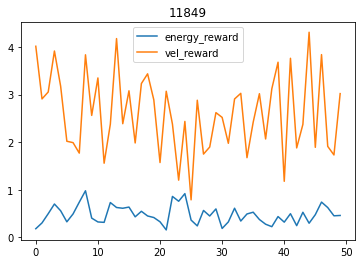

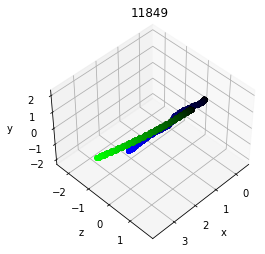

| eval  | E: 488 | S: 11849 | R: 106.6883
| train | E: 489 | S: 11849 | R: 104.2582 | D: 59.4 s | BR: 1.7426 | ALOSS: -41.4594 | CLOSS: 65.6898 | TLOSS: 0.0301 | TVAL: 0.0861 | AENT: -4.0000
| train | E: 490 | S: 11887 | R: 79.0934 | D: 107.0 s | BR: 1.7312 | ALOSS: -42.2866 | CLOSS: 44.9190 | TLOSS: -0.1934 | TVAL: 0.0861 | AENT: -4.0000
| train | E: 491 | S: 11914 | R: 48.5618 | D: 32.5 s | BR: 1.7703 | ALOSS: -42.5002 | CLOSS: 44.6210 | TLOSS: 0.1420 | TVAL: 0.0861 | AENT: -4.0000
| train | E: 492 | S: 11953 | R: 80.0031 | D: 47.9 s | BR: 1.7983 | ALOSS: -42.2392 | CLOSS: 58.8549 | TLOSS: 0.0579 | TVAL: 0.0862 | AENT: -4.0000
| train | E: 493 | S: 11983 | R: 61.5529 | D: 34.7 s | BR: 1.7595 | ALOSS: -42.4799 | CLOSS: 53.9455 | TLOSS: -0.3992 | TVAL: 0.0861 | AENT: -4.0000
| train | E: 494 | S: 12033 | R: 106.0261 | D: 60.1 s | BR: 1.7503 | ALOSS: -42.1710 | CLOSS: 62.0143 | TLOSS: 0.6573 | TVAL: 0.0862 | AENT: -4.0000
| train | E: 495 | S: 12083 | R: 116.1909 | D: 56.5 s | BR: 1.783

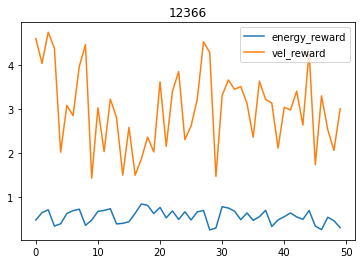

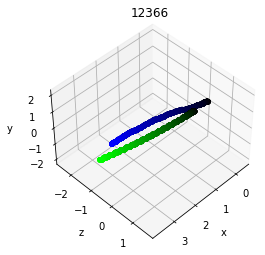

| eval  | E: 500 | S: 12366 | R: 122.4498
| train | E: 501 | S: 12366 | R: 109.0096 | D: 56.6 s | BR: 1.7576 | ALOSS: -42.9643 | CLOSS: 56.1283 | TLOSS: 0.4236 | TVAL: 0.0881 | AENT: -4.0000
| train | E: 502 | S: 12416 | R: 111.3932 | D: 118.7 s | BR: 1.7580 | ALOSS: -42.9182 | CLOSS: 67.2077 | TLOSS: 0.8853 | TVAL: 0.0887 | AENT: -4.0000
| train | E: 503 | S: 12463 | R: 112.0248 | D: 53.3 s | BR: 1.7468 | ALOSS: -43.1946 | CLOSS: 51.0379 | TLOSS: 1.9895 | TVAL: 0.0897 | AENT: -4.0000
| train | E: 504 | S: 12513 | R: 112.7465 | D: 58.1 s | BR: 1.7744 | ALOSS: -43.5569 | CLOSS: 58.4611 | TLOSS: 1.0475 | TVAL: 0.0912 | AENT: -4.0000
| train | E: 505 | S: 12543 | R: 60.6875 | D: 38.1 s | BR: 1.7470 | ALOSS: -43.1196 | CLOSS: 76.2975 | TLOSS: 0.7258 | TVAL: 0.0919 | AENT: -4.0000
| train | E: 506 | S: 12593 | R: 112.6619 | D: 59.2 s | BR: 1.8042 | ALOSS: -43.2268 | CLOSS: 57.6249 | TLOSS: 0.5308 | TVAL: 0.0924 | AENT: -4.0000
| train | E: 507 | S: 12643 | R: 113.6052 | D: 58.0 s | BR: 1.77

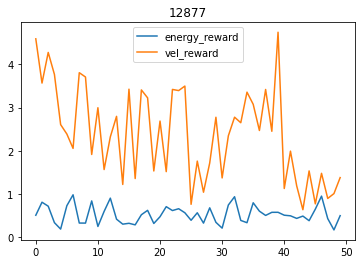

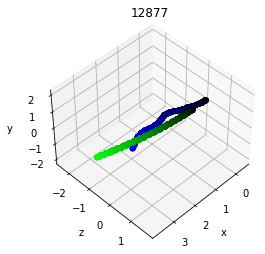

| eval  | E: 511 | S: 12877 | R: 93.4847
| train | E: 512 | S: 12877 | R: 63.5266 | D: 38.6 s | BR: 1.7742 | ALOSS: -43.5326 | CLOSS: 63.7843 | TLOSS: 0.1580 | TVAL: 0.0926 | AENT: -4.0000
| train | E: 513 | S: 12927 | R: 117.2644 | D: 114.1 s | BR: 1.8367 | ALOSS: -44.0509 | CLOSS: 51.3222 | TLOSS: -0.0144 | TVAL: 0.0927 | AENT: -4.0000
| train | E: 514 | S: 12977 | R: 108.3690 | D: 57.3 s | BR: 1.7922 | ALOSS: -43.6672 | CLOSS: 68.4193 | TLOSS: 0.6830 | TVAL: 0.0930 | AENT: -4.0000
| train | E: 515 | S: 13006 | R: 50.6811 | D: 34.2 s | BR: 1.7878 | ALOSS: -44.1871 | CLOSS: 56.5825 | TLOSS: -0.5501 | TVAL: 0.0933 | AENT: -4.0000
| train | E: 516 | S: 13050 | R: 94.0887 | D: 50.3 s | BR: 1.8026 | ALOSS: -44.0115 | CLOSS: 55.8784 | TLOSS: -0.4817 | TVAL: 0.0930 | AENT: -4.0000
| train | E: 517 | S: 13093 | R: 92.7980 | D: 51.3 s | BR: 1.8309 | ALOSS: -44.1463 | CLOSS: 57.7876 | TLOSS: -0.7998 | TVAL: 0.0924 | AENT: -4.0000
| train | E: 518 | S: 13139 | R: 93.9765 | D: 54.1 s | BR: 1.774

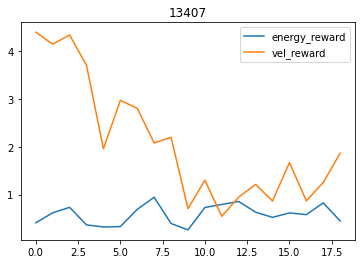

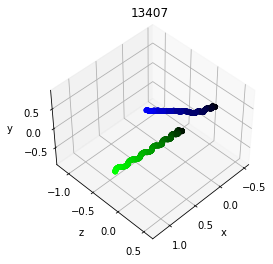

| eval  | E: 523 | S: 13407 | R: 28.7620
| train | E: 524 | S: 13407 | R: 117.4629 | D: 56.7 s | BR: 1.8244 | ALOSS: -44.6330 | CLOSS: 64.6074 | TLOSS: 0.7553 | TVAL: 0.0941 | AENT: -4.0000
| train | E: 525 | S: 13430 | R: 45.4245 | D: 36.3 s | BR: 1.8268 | ALOSS: -44.9853 | CLOSS: 62.8747 | TLOSS: 1.3182 | TVAL: 0.0948 | AENT: -4.0000
| train | E: 526 | S: 13451 | R: 40.3393 | D: 11.8 s | BR: 1.7880 | ALOSS: -44.4855 | CLOSS: 63.2804 | TLOSS: 1.2563 | TVAL: 0.0954 | AENT: -4.0000
| train | E: 527 | S: 13478 | R: 62.0216 | D: 13.7 s | BR: 1.8031 | ALOSS: -44.5007 | CLOSS: 73.4509 | TLOSS: 1.2656 | TVAL: 0.0961 | AENT: -4.0000
| train | E: 528 | S: 13502 | R: 49.0851 | D: 12.2 s | BR: 1.7990 | ALOSS: -44.7854 | CLOSS: 55.8876 | TLOSS: -0.1589 | TVAL: 0.0966 | AENT: -4.0000
| train | E: 529 | S: 13548 | R: 95.0097 | D: 53.0 s | BR: 1.7930 | ALOSS: -44.5277 | CLOSS: 70.3447 | TLOSS: 0.3437 | TVAL: 0.0967 | AENT: -4.0000
| train | E: 530 | S: 13598 | R: 108.6394 | D: 57.6 s | BR: 1.8151 | 

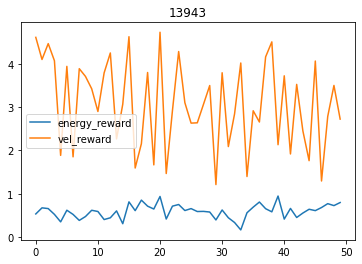

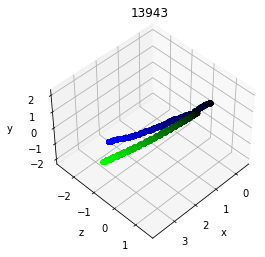

| eval  | E: 536 | S: 13943 | R: 124.1101
| train | E: 537 | S: 13943 | R: 117.1450 | D: 56.8 s | BR: 1.8138 | ALOSS: -45.2213 | CLOSS: 65.7447 | TLOSS: 0.8527 | TVAL: 0.0993 | AENT: -4.0000
| train | E: 538 | S: 13993 | R: 107.6956 | D: 116.6 s | BR: 1.8258 | ALOSS: -45.4325 | CLOSS: 62.8416 | TLOSS: 0.6583 | TVAL: 0.1002 | AENT: -4.0000
| train | E: 539 | S: 14043 | R: 112.5940 | D: 56.3 s | BR: 1.7902 | ALOSS: -45.1263 | CLOSS: 67.8194 | TLOSS: 0.8641 | TVAL: 0.1010 | AENT: -4.0000
| train | E: 540 | S: 14073 | R: 56.0231 | D: 38.6 s | BR: 1.8302 | ALOSS: -45.8930 | CLOSS: 58.1910 | TLOSS: 0.4227 | TVAL: 0.1019 | AENT: -4.0000
| train | E: 541 | S: 14123 | R: 116.8789 | D: 57.9 s | BR: 1.8356 | ALOSS: -45.3279 | CLOSS: 71.7124 | TLOSS: -0.0057 | TVAL: 0.1022 | AENT: -4.0000
| train | E: 542 | S: 14173 | R: 107.4303 | D: 61.0 s | BR: 1.8422 | ALOSS: -45.9352 | CLOSS: 63.3078 | TLOSS: 1.0046 | TVAL: 0.1027 | AENT: -4.0000
| train | E: 543 | S: 14197 | R: 40.7427 | D: 29.7 s | BR: 1.86

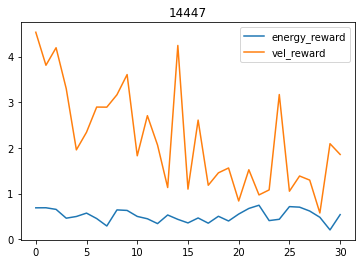

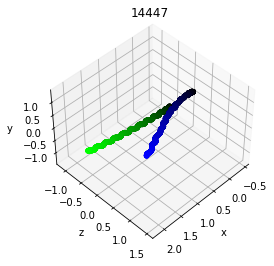

| eval  | E: 547 | S: 14447 | R: 52.4253
| train | E: 548 | S: 14447 | R: 107.2375 | D: 60.6 s | BR: 1.8604 | ALOSS: -45.7431 | CLOSS: 72.0580 | TLOSS: 0.5517 | TVAL: 0.1043 | AENT: -4.0000
| train | E: 549 | S: 14467 | R: 30.2189 | D: 62.5 s | BR: 1.8148 | ALOSS: -45.8115 | CLOSS: 62.7095 | TLOSS: 1.5636 | TVAL: 0.1049 | AENT: -4.0000
| train | E: 550 | S: 14504 | R: 68.0328 | D: 43.8 s | BR: 1.8589 | ALOSS: -45.7143 | CLOSS: 66.3193 | TLOSS: 0.4109 | TVAL: 0.1057 | AENT: -4.0000
| train | E: 551 | S: 14554 | R: 115.9075 | D: 60.9 s | BR: 1.8223 | ALOSS: -45.8293 | CLOSS: 59.9639 | TLOSS: -0.2287 | TVAL: 0.1060 | AENT: -4.0000
| train | E: 552 | S: 14604 | R: 111.6811 | D: 56.4 s | BR: 1.8663 | ALOSS: -46.2119 | CLOSS: 54.4999 | TLOSS: 0.2171 | TVAL: 0.1058 | AENT: -4.0000
| train | E: 553 | S: 14638 | R: 67.5321 | D: 42.4 s | BR: 1.8226 | ALOSS: -45.8247 | CLOSS: 68.7736 | TLOSS: -0.0502 | TVAL: 0.1061 | AENT: -4.0000
| train | E: 554 | S: 14688 | R: 119.2374 | D: 56.3 s | BR: 1.8345

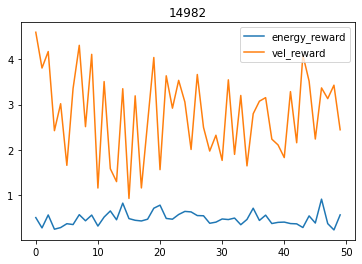

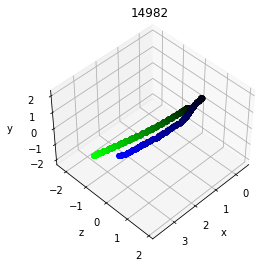

| eval  | E: 559 | S: 14982 | R: 114.6347
| train | E: 560 | S: 14982 | R: 115.3351 | D: 56.2 s | BR: 1.8269 | ALOSS: -46.5360 | CLOSS: 62.3883 | TLOSS: -0.2570 | TVAL: 0.1047 | AENT: -4.0000
| train | E: 561 | S: 15032 | R: 115.0031 | D: 120.3 s | BR: 1.8271 | ALOSS: -46.2682 | CLOSS: 70.3598 | TLOSS: -0.1613 | TVAL: 0.1043 | AENT: -4.0000
| train | E: 562 | S: 15082 | R: 102.2907 | D: 61.4 s | BR: 1.8586 | ALOSS: -46.3658 | CLOSS: 68.4578 | TLOSS: -0.2399 | TVAL: 0.1041 | AENT: -4.0000
| train | E: 563 | S: 15132 | R: 105.5204 | D: 56.6 s | BR: 1.8235 | ALOSS: -46.6331 | CLOSS: 56.4081 | TLOSS: -0.6550 | TVAL: 0.1035 | AENT: -4.0000
| train | E: 564 | S: 15182 | R: 111.8448 | D: 60.9 s | BR: 1.8888 | ALOSS: -47.0099 | CLOSS: 57.6885 | TLOSS: -0.3030 | TVAL: 0.1028 | AENT: -4.0000
| train | E: 565 | S: 15232 | R: 121.8030 | D: 56.5 s | BR: 1.8706 | ALOSS: -46.8514 | CLOSS: 61.9541 | TLOSS: -0.0163 | TVAL: 0.1024 | AENT: -4.0000
| train | E: 566 | S: 15282 | R: 114.0955 | D: 61.6 s | B

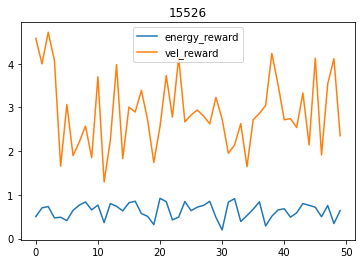

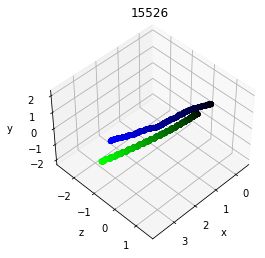

| eval  | E: 570 | S: 15526 | R: 113.1063
| train | E: 571 | S: 15526 | R: 123.6657 | D: 56.8 s | BR: 1.8542 | ALOSS: -46.7366 | CLOSS: 62.5079 | TLOSS: 0.5133 | TVAL: 0.1038 | AENT: -4.0000
| train | E: 572 | S: 15576 | R: 111.9721 | D: 118.5 s | BR: 1.8950 | ALOSS: -47.1173 | CLOSS: 59.7940 | TLOSS: 0.4388 | TVAL: 0.1045 | AENT: -4.0000
| train | E: 573 | S: 15626 | R: 114.0546 | D: 61.8 s | BR: 1.8548 | ALOSS: -46.9722 | CLOSS: 69.4405 | TLOSS: 0.1171 | TVAL: 0.1049 | AENT: -4.0000
| train | E: 574 | S: 15676 | R: 113.6734 | D: 57.9 s | BR: 1.8752 | ALOSS: -47.2965 | CLOSS: 61.2525 | TLOSS: 0.4951 | TVAL: 0.1053 | AENT: -4.0000
| train | E: 575 | S: 15726 | R: 118.0438 | D: 60.4 s | BR: 1.8813 | ALOSS: -47.7474 | CLOSS: 55.2588 | TLOSS: 0.5524 | TVAL: 0.1061 | AENT: -4.0000
| train | E: 576 | S: 15776 | R: 117.8202 | D: 58.0 s | BR: 1.8800 | ALOSS: -47.2338 | CLOSS: 72.3257 | TLOSS: -0.2187 | TVAL: 0.1067 | AENT: -4.0000
| train | E: 577 | S: 15826 | R: 115.6362 | D: 60.9 s | BR: 1.

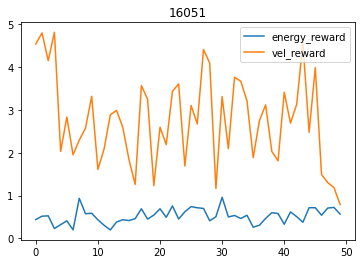

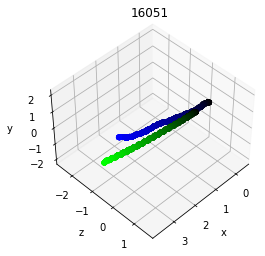

| eval  | E: 581 | S: 16051 | R: 112.1848
| train | E: 582 | S: 16051 | R: 106.9843 | D: 59.3 s | BR: 1.9236 | ALOSS: -47.9908 | CLOSS: 61.6843 | TLOSS: -0.4072 | TVAL: 0.1045 | AENT: -4.0000
| train | E: 583 | S: 16086 | R: 75.3787 | D: 100.6 s | BR: 1.8709 | ALOSS: -47.4319 | CLOSS: 71.9337 | TLOSS: -0.6111 | TVAL: 0.1039 | AENT: -4.0000
| train | E: 584 | S: 16126 | R: 80.5897 | D: 48.7 s | BR: 1.8393 | ALOSS: -46.9542 | CLOSS: 85.2246 | TLOSS: -0.3611 | TVAL: 0.1034 | AENT: -4.0000
| train | E: 585 | S: 16176 | R: 111.5675 | D: 56.5 s | BR: 1.8647 | ALOSS: -47.8167 | CLOSS: 64.0601 | TLOSS: 0.0349 | TVAL: 0.1032 | AENT: -4.0000
| train | E: 586 | S: 16198 | R: 42.5808 | D: 28.8 s | BR: 1.8968 | ALOSS: -48.3143 | CLOSS: 48.2929 | TLOSS: 0.1275 | TVAL: 0.1031 | AENT: -4.0000
| train | E: 587 | S: 16248 | R: 108.8526 | D: 56.6 s | BR: 1.8988 | ALOSS: -47.7888 | CLOSS: 72.1881 | TLOSS: 0.1032 | TVAL: 0.1032 | AENT: -4.0000
| train | E: 588 | S: 16298 | R: 99.2644 | D: 56.7 s | BR: 1.87

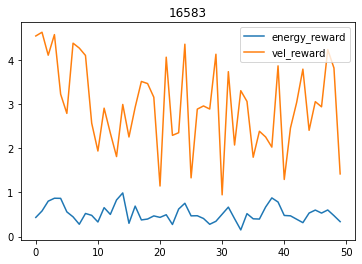

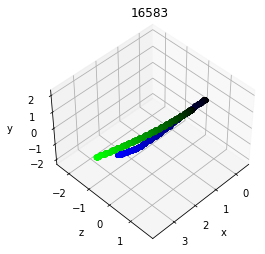

| eval  | E: 593 | S: 16583 | R: 122.5918
| train | E: 594 | S: 16583 | R: 116.1566 | D: 62.1 s | BR: 1.8924 | ALOSS: -48.6083 | CLOSS: 59.9580 | TLOSS: 0.7964 | TVAL: 0.1047 | AENT: -4.0000
| train | E: 595 | S: 16633 | R: 111.7474 | D: 113.1 s | BR: 1.9058 | ALOSS: -48.5851 | CLOSS: 70.8835 | TLOSS: 0.1691 | TVAL: 0.1056 | AENT: -4.0000
| train | E: 596 | S: 16674 | R: 86.4406 | D: 52.0 s | BR: 1.8471 | ALOSS: -48.2667 | CLOSS: 73.3277 | TLOSS: -0.0764 | TVAL: 0.1057 | AENT: -4.0000
| train | E: 597 | S: 16724 | R: 110.3326 | D: 57.1 s | BR: 1.8922 | ALOSS: -48.4221 | CLOSS: 70.6500 | TLOSS: -0.4788 | TVAL: 0.1054 | AENT: -4.0000
| train | E: 598 | S: 16774 | R: 109.4075 | D: 59.6 s | BR: 1.8598 | ALOSS: -48.7167 | CLOSS: 64.7643 | TLOSS: -0.7921 | TVAL: 0.1044 | AENT: -4.0000
| train | E: 599 | S: 16824 | R: 98.6005 | D: 57.1 s | BR: 1.8910 | ALOSS: -49.0064 | CLOSS: 55.6236 | TLOSS: -0.2423 | TVAL: 0.1037 | AENT: -4.0000
| train | E: 600 | S: 16863 | R: 75.3224 | D: 44.9 s | BR: 1.

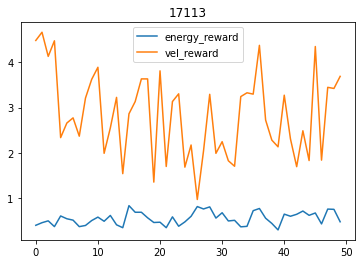

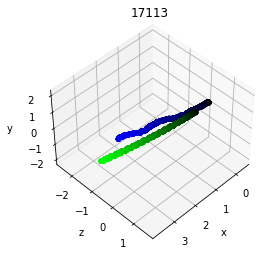

| eval  | E: 604 | S: 17113 | R: 114.7606
| train | E: 605 | S: 17113 | R: 116.3911 | D: 57.0 s | BR: 1.9049 | ALOSS: -48.9965 | CLOSS: 67.4063 | TLOSS: -0.3805 | TVAL: 0.1027 | AENT: -4.0000
| train | E: 606 | S: 17163 | R: 123.7862 | D: 120.3 s | BR: 1.8910 | ALOSS: -49.3108 | CLOSS: 63.3786 | TLOSS: -0.1226 | TVAL: 0.1023 | AENT: -4.0000
| train | E: 607 | S: 17213 | R: 104.6414 | D: 60.3 s | BR: 1.9174 | ALOSS: -49.2485 | CLOSS: 69.7452 | TLOSS: 0.0709 | TVAL: 0.1023 | AENT: -4.0000
| train | E: 608 | S: 17263 | R: 124.0879 | D: 56.1 s | BR: 1.8691 | ALOSS: -49.2030 | CLOSS: 67.7698 | TLOSS: 0.3705 | TVAL: 0.1024 | AENT: -4.0000
| train | E: 609 | S: 17293 | R: 57.3215 | D: 39.5 s | BR: 1.8797 | ALOSS: -49.3520 | CLOSS: 68.6501 | TLOSS: 0.6239 | TVAL: 0.1030 | AENT: -4.0000
| train | E: 610 | S: 17343 | R: 123.3048 | D: 56.3 s | BR: 1.8812 | ALOSS: -49.5009 | CLOSS: 61.8594 | TLOSS: -0.0401 | TVAL: 0.1034 | AENT: -4.0000
| train | E: 611 | S: 17393 | R: 106.8125 | D: 60.5 s | BR: 1

KeyboardInterrupt: 

In [26]:
while step < num_train_steps:
    samples = collect_traj()
    for sample in samples:
        obs,action,next_obs,reward,done = sample
        if done:
            logger.log('train/duration',time.time() - start_time, step)
            start_time = time.time()
            # evaluate agent periodically
            if step >=next_eval_steps:
                # save model
                agent.save(model_folder+"steps_{0}".format(step))
                logger.log('eval/episode', episode, step)
                next_eval_steps = step+eval_frequency
                evaluate()
            logger.log('train/episode_reward', episode_reward,step)
            episode_reward = 0
            episode += 1
            logger.log('train/episode', episode, step)
            logger.dump(step, save=True,ty='train')
        # run training update
        log_data = agent.train(gradient_steps,batch_size)
        logger.log_data(log_data,step)
        done = float(done)
        episode_reward += reward
        step += 1
        agent.replay_buffer.add(obs, action, reward, next_obs, done)

In [27]:
torch.save({'buffer':agent.replay_buffer},model_folder+'buffer')
torch.save({'actor':agent.actor.state_dict()},model_folder+'actor')
agent.save(model_folder+'model')

In [28]:
network_folder

'/root/pytorch_fish/output_data/2021-05-31/test school without markers  vel follow_2021-05-31 04:10/networks/'

## Evaluation and Test

In [29]:
evaluate_save_fluid=True
evaluate_save_data=True

In [30]:
def evaluate_traj(goal_pos,target_vel,step_budget):
#         print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
#         skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
#         skeleton_dynamics.getJoint("head").setVelocity(0,0)
#         skeleton_dynamics.getJoint("head").setVelocity(1,0)
#         joint_list =['spine','spine01','spine02','spine03']
#         for jnt_name in joint_list:
#             skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#             skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


#         skeleton_dynamics.update()
        env.set_task(goal_pos,target_vel,step_budget)
        ref_line = fl.debugLine()
        ref_line.vertices = [
                    env.init_pos*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
                ]
        fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")
#         agent.reset()
        done = False
        episode_reward = 0
        infos = []
        while not done:
            action, _states = model.predict(obs, deterministic=False)
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
        plot_infos(infos,title="str(theta)")
        env.plot3d()

Evaluating episode 0 ....


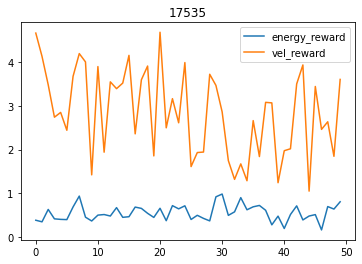

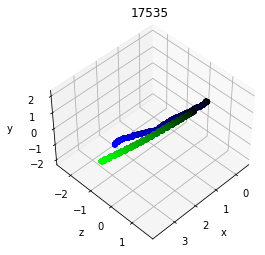

| eval  | E: 0 | S: 17535 | R: 114.7012


In [31]:
evaluate()

In [ ]:
!./clean_visdata.sh

thetaa = 0
goal_dir = np.array([math.cos(thetaa),0,math.sin(thetaa)])
goal_pos = goal_dir*1
target_vel = 0.1
budget = 1.0
evaluate_traj(goal_pos,target_vel,budget)

In [ ]:
ref_line = fl.debugLine()
ref_line.vertices = [
            env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
        ]
fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")

In [ ]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [ ]:
%matplotlib notebook

In [ ]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [ ]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [ ]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


# skeleton_dynamics.update()
t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 

env.set_task(goal_pos ,0.1,1.0)

# skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)
# env.set_datapath(store_folder+'/data/')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while True:
    if env.rigid_data.rigidWorld.time>50 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break 
    obs = env._get_obs()
    observations.append(obs)
    action, _states = model.predict(obs, deterministic=True)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.stepSave(action,save_objects=True,save_fluid=True)
    
    if np.linalg.norm(env.body_xyz-env.goal_pos)<0.3:
        t = t+dt
        env.set_task(traj.getPose(t).getPosition() ,0.1,1.0)
    plot_env(env,ax)
plt.close(fig)


In [ ]:
        
while env.rigid_data.rigidWorld.time<10:
    env.stepSave(np.ones(env.action_dim)*0,save_objects=True,save_fluid=False,test_mode=True)

In [ ]:
env.couple_mode =  fl.COUPLE_MODE.TWO_WAY
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)

# skeleton_dynamics.update()

t = 0.001
dt = 0.08

startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)


env.simulator.mainDataFolderPath = store_folder+'/data/'
env.dataPath = {}
env.dataPath["fluid"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.fluidFolderName + '/').resolve())
env.dataPath["objects"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.objectsFolderName + '/').resolve())
env.dataPath["trajectory"] = str(Path(env.simulator.mainDataFolderPath + 'Trajectory/').resolve())
if not os.path.exists(env.simulator.mainDataFolderPath):
    os.makedirs(env.simulator.mainDataFolderPath)
for p in env.dataPath.values():
    if not os.path.exists(p):
        os.makedirs(p)



env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
        
while env.rigid_data.rigidWorld.time<3:
    env.stepSave(np.ones(env.action_dim)*0,save_objects=True,save_fluid=False,test_mode=True)

In [ ]:
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),vels)
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
# plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()
plt.figure()
# plt.plot(np.arange(0,len(actions),1),[ 0.1* np.sum(np.abs(a)**2) for a in actions])
plt.plot(np.arange(0,len(actions),1),[ a[1] for a in actions])
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()